In [1]:
import matplotlib.pyplot as plt
import numpy as np

from commstools import SystemConfig, set_config, set_backend
from commstools.dsp.sequences import prbs
from commstools.dsp.waveforms import ook


In [2]:
set_backend("numpy")

config = SystemConfig(sampling_rate=1e6, samples_per_symbol=8)
set_config(config)

bits = np.concatenate(
    (
        prbs(500, seed=0x123456221, order=31),
        prbs(500, seed=0x123656221, order=31),
        prbs(500, seed=0x123658721, order=31),
        prbs(500, seed=0x123658938, order=31),
    )
)

sig_delta = ook(bits, pulse_shape="delta")
sig_rect = ook(bits, pulse_shape="rect")
sig_gauss = ook(bits, pulse_shape="gaussian", bt=0.2, span=10)
sig_rrc = ook(bits, pulse_shape="rrc", rolloff=0.1, span=10)


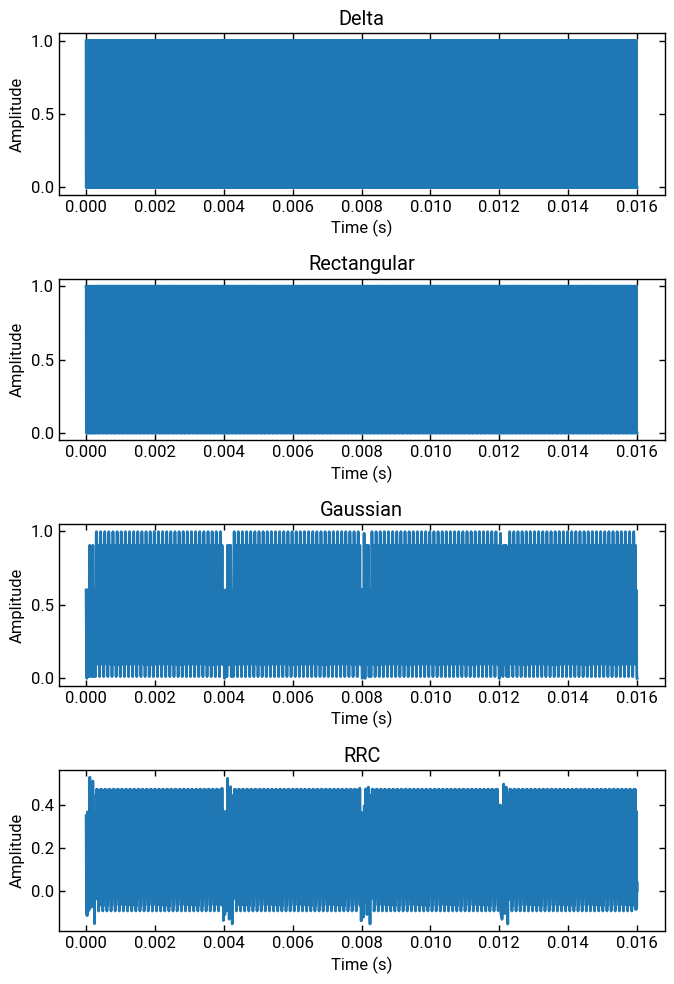

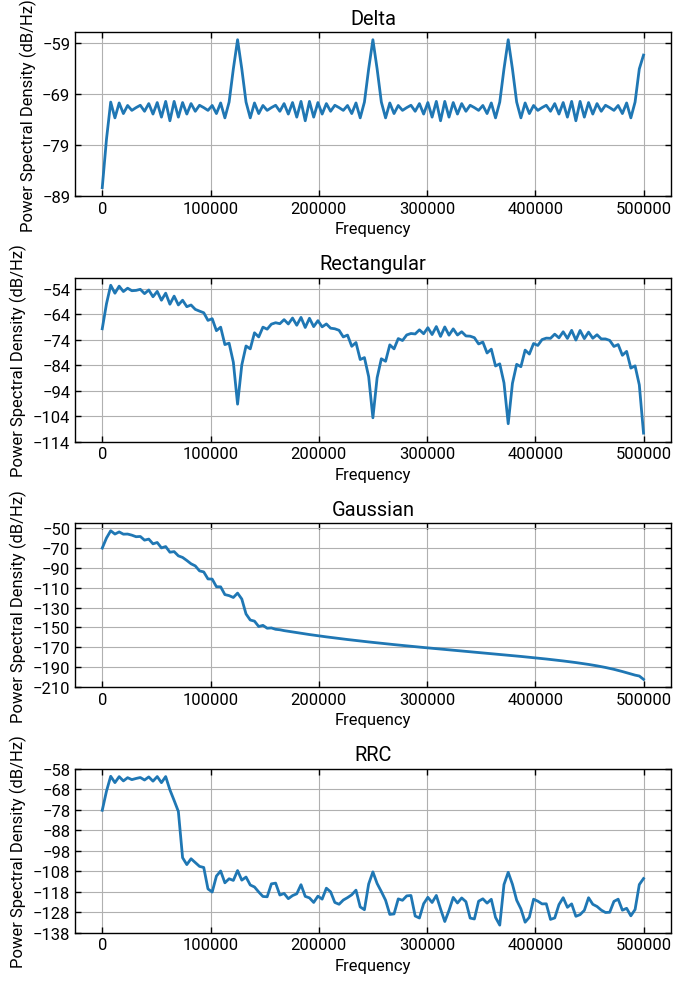

In [3]:
fig, axs = plt.subplots(4, 1, figsize=(7, 10))

sig_delta.plot_signal(ax=axs[0])
axs[0].set_title("Delta")
sig_rect.plot_signal(ax=axs[1])
axs[1].set_title("Rectangular")
sig_gauss.plot_signal(ax=axs[2])
axs[2].set_title("Gaussian")
sig_rrc.plot_signal(ax=axs[3])
axs[3].set_title("RRC")

plt.show()

fig, axs = plt.subplots(4, 1, figsize=(7, 10))

sig_delta.plot_psd(ax=axs[0])
axs[0].set_title("Delta")
sig_rect.plot_psd(ax=axs[1])
axs[1].set_title("Rectangular")
sig_gauss.plot_psd(ax=axs[2])
axs[2].set_title("Gaussian")
sig_rrc.plot_psd(ax=axs[3])
axs[3].set_title("RRC")

plt.show()


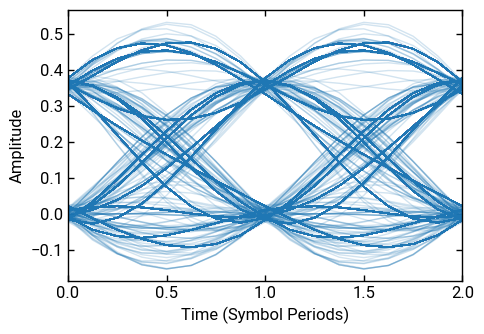

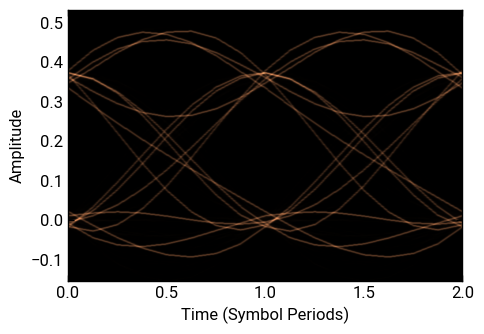

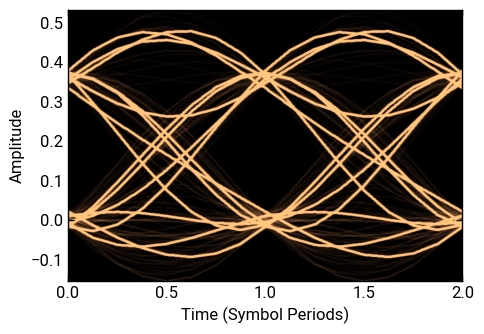

In [4]:
sig_rrc.plot_eye()
sig_rrc.plot_eye(plot_type="hist")
sig_rrc.plot_eye(plot_type="hist", vmax=0.06)
plt.show()
